In [2]:
#import

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from scipy.optimize import minimize

In [3]:
#parameter

ng = 1.517 #diffractive index of glass
lam = 852e-9 #wave length[m]
R = 40e-3 #curvature radius[m]
L = 8.4e-3 #length of cavity[m]
f = np.array([30,40,50,75,100,125,150,200,250,300,400,500,750,1000])*1e-3 #focus length[m]

lens cavityのときと異なり、共振器内の媒質が空気なのでn=1で計算する。\
共振器に入射する時はn=1.517のBK7というガラスを透過する。

In [4]:
#stability condition of FilterCavity

def stabCal(L,R,lam,n=1):
    ML = np.array([[1,L/n],[0,1]])
    MR = np.array([[1,0],[-2/R,1]]) #曲面鏡での反射

    M = np.matmul(MR,ML)
    M = np.matmul(ML,M)
    M = np.matmul(MR,M)

    A=M[0][0]
    B=M[0][1]
    C=M[1][0]
    D=M[1][1]

    R_cav = 2*B/(D-A)
    Omega_cav = np.sqrt(2*B*lam/(np.pi*n*np.sqrt(4-(A+D)**2)))
    return R_cav, Omega_cav

R_cav = stabCal(L,R,lam)[0]
print("R_cav=",R_cav)
Omega_cav = stabCal(L,R,lam)[1]
print("Omega_cav=",Omega_cav,"[m]")

R_cav= -0.04
Omega_cav= 6.0955994702312964e-05 [m]


この結果からlens cavityでは入射面においてbeam waistが来るようにし,なおかつそのbeam waistを所望のsizeに変換する必要があることがわかった.\
そのbeam径の変換はlensによっておこなう. 以下では,そのlensの焦点距離と位置を見積もっていく.\
見積もりの方法はlensの数:one or twoとlen前のbeamのcollimationの状態が完全と仮定するか否かによって、4通りの方法がある.

# Collimation check

コリメートが正確にできているかは、レイリー長を計算することで見積もることができる.\
光学系におけるパスの全長よりもレイリー長が十分長ければ、その光学系の中では平行光であるとみなしてよい.

beam waist position -0.19705940510920833 [m]
beam waist radius 7.932731833503981e-05 [m]
Rayleigh length: 0.02320362426210178 [m]


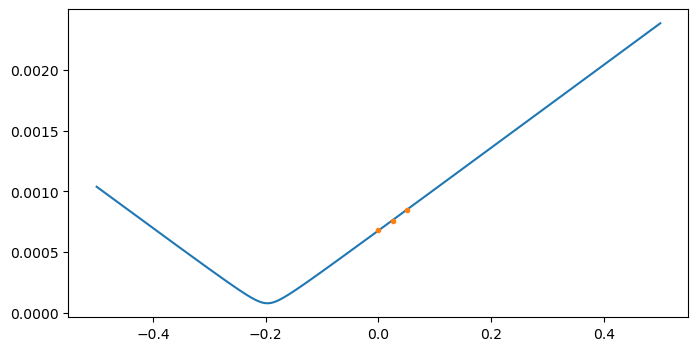

In [5]:
zs = np.array([0, 25, 50])*1e-3 #[m]
ws = np.array([680, 760, 850])*1e-6 #[m]

n = 1

#任意の位置:zにおけるビーム径を
def waist(z, z0, w0):
    z_R = np.pi*w0**2*n/lam #Rayleigh length
    return w0*np.sqrt(1 + ((z-z0)/z_R)**2)

z = np.linspace(-500e-3, 500e-3, 1001)

popt, pcov = curve_fit(waist, zs, ws)
print("beam waist position",popt[0],"[m]")
print("beam waist radius",popt[1],"[m]")
print("Rayleigh length:",np.pi*popt[1]**2*n/lam,"[m]")

plt.figure(figsize=(8,4))
plt.plot(z, waist(z, *popt))
plt.plot(zs, ws, '.')
plt.show()

# Perfect collimation condition (for two lens)

lensに入射する光が完全に平行光であると仮定したうえで, 焦点距離:f1のlens1, lens1とlens2間の距離:d1, 焦点距離:f2のlens2, lens2とlens cavity間の距離:d2の伝搬を光線行列で追跡する.\
元のgaussian beamを十分collimationした上で, beam radiusを測定し,それを上述の光線行列により絞った後のbeam radius: Omega_dashを計算する.\
その値がOmega_cavに最も近いlensを採用し, 位置:d2,d3を最適化するという方針である.

In [10]:
# caution: beam profiler output is diameter, not radius 
Omega0 = 703.5e-6 #[m]
f = np.array([30,40,50,100,150,200,250,300,400,500,1000])*1e-3 #focus length[m]

# 光線行列
def matrixCal(d, f1, f2, n):
    d2 = d[0]
    d3 = d[1]
    Mf1 = np.array([[1, 0], [-1 / f1, 1]])
    Mf2 = np.array([[1, 0], [-1 / f2, 1]])
    Md2 = np.array([[1, d2], [0, 1]])
    Md3 = np.array([[1, d3], [0, 1]])
    Mn = np.array([[1, 0], [0, 1/n]])
    M = np.matmul(Md2, Mf1)
    M = np.matmul(Mf2, M)
    M = np.matmul(Md3, M)
    M = np.matmul(Mn, M)
    A = M[0][0]
    B = M[0][1]
    C = M[1][0]
    D = M[1][1]
    q_in = 1j * np.pi * Omega0 ** 2 / lam
    q_out = (A * q_in + B) / (C * q_in + D)
    Omega_dash = np.sqrt(q_out.imag * lam / np.pi)
    CurvatureRadius_dash = 2*B/(D-A)
    return Omega_dash, CurvatureRadius_dash, D-A

# 目的関数
def objective(d, f1, f2, n):
    radius_error = (matrixCal(d, f1, f2, n)[0] - Omega0) ** 2 #二乗誤差
    return radius_error

# 曲率半径制約(D-A=0)
def curvature_constraint(d, f1, f2, n):
    return matrixCal(d, f1, f2, n)[2]

# parameter:d2,d3の範囲制約と初期値の定義
tube_length = 0.0508 #[m]
#candidate: 50.8, 63.5, 76.3, 88.9[mm]
bounds = [(tube_length, tube_length+0.0333), (0.03, 0.13)]  # d2とd3の範囲[m]
initial_guess = [(bounds[0][0]+bounds[0][1])/2, (bounds[1][0]+bounds[1][1])/2]  # d2とd3の初期値[m]

# 最適化ループ
final_list = []
for i in f:  # f1
    for j in f:  # f2
        constraints = {
            'type': 'eq',  # 等式制約
            'fun': curvature_constraint,
            'args': (i, j, ng)
        }
        result = minimize(objective, initial_guess, args=(i, j, ng), bounds=bounds, constraints=constraints)
        if result.success:
            optimized_d2 = result.x[0]
            optimized_d3 = result.x[1]
            final_radius, final_curvature, _ = matrixCal([optimized_d2,optimized_d3], i, j, ng)
            final_list.append((final_radius, optimized_d2, optimized_d3, i, j, final_curvature)) #[m]


# 最適な結果を表示
if final_list:
    closest_radius = min(final_list, key=lambda x: abs(x[0] - Omega_cav))
    print("Omega cavity:", Omega_cav,"[m]")
    print(f"final radius: {closest_radius[0]}[m]")
    print(f"d2: {closest_radius[1] * 1e2} [cm], d3: {closest_radius[2] * 1e2} [cm]")
    print(f"focus length 1: {closest_radius[3] * 1e3} [mm], focus length 2: {closest_radius[4] * 1e3} [mm]")
    print(f"final cuevature radius:{closest_radius[5]}[m]")

Omega cavity: 5.414702904835464e-05 [m]
final radius: 5.426984348202896e-05[m]
d2: 7.905151842860188 [cm], d3: 4.183420503150293 [cm]
focus length 1: 250.0 [mm], focus length 2: 150.0 [mm]
final cuevature radius:19750520077.71845[m]


# Imperfect collimation condition (for two lens)

waist position: 0.1564118792585124 [m]
beam waist: 0.00021543671034410318 [m]


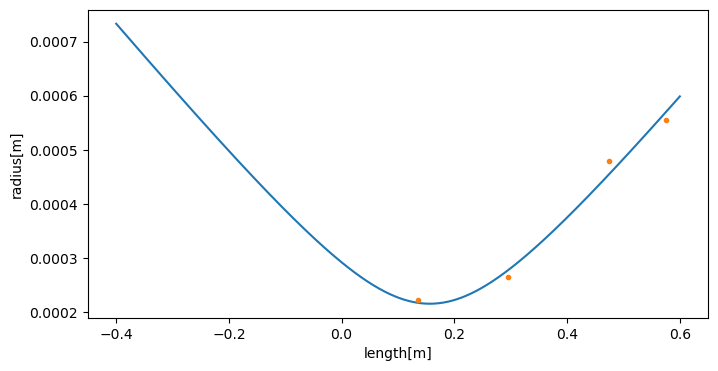

In [13]:
zs = np.array([135, 295, 475, 575])*1e-3 #[m]
ws = np.array([222, 265, 480, 555])*1e-6 #[m]

n_air = 1
lam = 852.3e-9

#任意の位置:zにおけるビーム径を
def waist(z, z0, w0):
    z_R = np.pi*w0**2*n_air/lam #Rayleigh length
    return w0*np.sqrt(1 + ((z-z0)/z_R)**2)

z = np.linspace(-400e-3, 600e-3, 1001)

popt, pcov = curve_fit(waist, zs, ws, maxfev=5000000)
Waist_position = popt[0]
print("waist position:",Waist_position,"[m]")
Omega0 = popt[1] 
print("beam waist:",Omega0,"[m]")

plt.figure(figsize=(8,4))
plt.plot(z, waist(z, *popt))
plt.plot(zs, ws, '.')
plt.xlabel("length[m]")
plt.ylabel("radius[m]")
plt.show()

In [ ]:
#two lens version  

def matrixCal(d,f1,f2,n):
    d1=d[0]
    d2=d[1]
    d3=d[2]
    Mf1 = np.array([[1,0],[-1/f1,1]])
    Mf2 = np.array([[1,0],[-1/f2,1]])
    Md1 = np.array([[1,d1],[0,1]])
    Md2 = np.array([[1,d2],[0,1]])
    Md3 = np.array([[1,d3],[0,1]])
    Mn = np.array([[1,0],[0,1/n]]) #自由空間からlensに入射する時の平面境界での屈折

    M=np.matmul(Mf1,Md1)
    M=np.matmul(Md2,M)
    M=np.matmul(Mf2,M)
    M=np.matmul(Md3,M)
    M=np.matmul(Mn,M)
    

    A=M[0][0]
    B=M[0][1]
    C=M[1][0]
    D=M[1][1]

    q_in = 1j*np.pi*Omega0**2/lam
    q_out = (A*q_in+B)/(C*q_in+D)
    Omega_dash = np.sqrt(q_out.imag*lam/np.pi)
    return Omega_dash, D-A

def objective(d,d2,f1,f2,n):
    diameter_error = (matrixCal(d,d2,f1,f2,n)[0]- Omega_cav)**2
    return diameter_error

def curvature_constraint(d,d2,f1,f2,n):
    current_curvature_radius = matrixCal(d,d2,f1,f2,n)[1]
    return current_curvature_radius

In [29]:
#two lens version  

def matrixCal(d,d2,f1,f2,n):
    d1=d[0]
    d3=d[1]
    Mf1 = np.array([[1,0],[-1/f1,1]])
    Mf2 = np.array([[1,0],[-1/f2,1]])
    Md1 = np.array([[1,d1],[0,1]])
    Md2 = np.array([[1,d2],[0,1]])
    Md3 = np.array([[1,d3],[0,1]])
    Mn = np.array([[1,0],[0,1/n]]) #自由空間からlensに入射する時の平面境界での屈折

    M=np.matmul(Mf1,Md1)
    M=np.matmul(Md2,M)
    M=np.matmul(Mf2,M)
    M=np.matmul(Md3,M)
    M=np.matmul(Mn,M)

    A=M[0][0]
    B=M[0][1]
    C=M[1][0]
    D=M[1][1]

    q_in = 1j*np.pi*Omega0**2/lam
    q_out = (A*q_in+B)/(C*q_in+D)
    Omega_dash = np.sqrt(q_out.imag*lam/np.pi)
    return Omega_dash, D-A

def objective(d,d2,f1,f2,n):
    diameter_error = (matrixCal(d,d2,f1,f2,n)[0]- Omega_cav)**2
    return diameter_error

def curvature_constraint(d,d2,f1,f2,n):
    current_curvature_radius = matrixCal(d,d2,f1,f2,n)[1]
    return current_curvature_radius

In [31]:
bounds = [(0.2, 0.5), (0, 0.15)]  # d1とd3の範囲
initial_guess = [(bounds[0][0]+bounds[0][1])/2, (bounds[1][0]+bounds[1][1])/2]  # d1とd3の初期値
tube_length = np.arange(0.05,0.2,0.01) #[m]

In [34]:
for i in f: #f1
    for j in f: #f2
        for k in tube_length: #d2
            #制約の定義
            constraints = {
            'type': 'eq',  #等式制約
            'fun': curvature_constraint,
            'args': (k,i,j,ng)
            }
            result = minimize(objective, initial_guess, args=(k,i,j,ng), bounds=bounds, constraints=constraints)
            if result.success:
                optimized_d1, optimized_d3 = result.x
                final_diameter = matrixCal([optimized_d1,optimized_d3],k,i,j,ng)[0]
                final_curvature = matrixCal([optimized_d1,optimized_d3],k,i,j,ng)[1]
                print(f"focus length 1: {i*1e3}[mm], focus length 2: {j*1e3}[mm]")
                print(f"Optimized d1: {optimized_d1*1e3}[mm], Optimized d2: {optimized_d3*1e3}[mm]")
                print(f"Final diameter: {final_diameter}, Final curvature radius: {final_curvature}")
                #print(f"Final objective function value: {result.fun}")
            else:
                print("Optimization failed")

focus length 1: 30.0[mm], focus length 2: 30.0[mm]
Optimized d1: 244.91999940971573[mm], Optimized d2: 150.0[mm]
Final diameter: 2.858217062692906e-05, Final curvature radius: 4.517020979477593e-09
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
focus length 1: 30.0[mm], focus length 2: 30.0[mm]
Optimized d1: 200.17200002820823[mm], Optimized d2: 149.99999999999997[mm]
Final diameter: 5.3651731077911845e-06, Final curvature radius: 2.1585773168908418e-09
focus length 1: 30.0[mm], focus length 2: 30.0[mm]
Optimized d1: 200.54181795547467[mm], Optimized d2: 150.0[mm]
Final diameter: 4.842504483627173e-06, Final curvature radius: -1.905247870581661e-08
focus length 1: 30.0[mm], focus length 2: 30.0[mm]
Optimized d1: 200.84999975657846[mm], Optimized d2: 150.0[mm]
Final diameter: 4.41262756986673e-06, Final curvature radius: -2.235275431416

# 確認用コード

In [45]:
def func(x):
    return x**2+2*x-3

x0 = fsolve(func,0)
x0

array([1.])

In [74]:
def func(x,a,b):
    return x**2+a*x+b

x0 = fsolve(func,0,args=(4,3))
x0

array([-1.])

In [4]:
def func(x):
    return [x[0] * np.cos(x[1]) - 4,
            x[1] * x[0] - x[1] - 5]

root = fsolve(func, [1, 1])
root

array([6.50409711, 0.90841421])